In [1]:
!pip install hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 34.5 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=32ab331bafcb82c3691d9ec687e34273700ae44ad6b3fc3fb16018b2723b471d
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [1]:
import csv, re
from hazm import *
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoConfig, AutoTokenizer, TFAutoModel
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Using open with 'r' to read from TSV file
with open('train.tsv', 'r', newline='') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')

    # Convert to a list of lists
    data = [row for row in reader]

# Convert the list of lists to a DataFrame with headers
train_df = pd.DataFrame(data, columns=['comments', 'labels'])


# Using open with 'r' to read from TSV file
with open('Project_Test - testset.tsv', 'r', newline='') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')

    # Convert to a list of lists
    data = [row for row in reader]

# Convert the list of lists to a DataFrame with headers
test_df = pd.DataFrame(data, columns=['comments', 'labels'])

# convert to np array
x_train = np.array(train_df["comments"])
y_train = np.array(train_df["labels"])
x_test = np.array(test_df["comments"])
y_test = np.array(test_df["labels"])

In [3]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = doc.replace("#", " ")
    doc = doc.replace("_", " ")
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)

    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    # tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)

    # # removing wierd patterns
    # wierd_pattern = re.compile("["
    #     u"\U0001F600-\U0001F64F"  # emoticons
    #     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    #     u"\U0001F680-\U0001F6FF"  # transport & map symbols
    #     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    #     u"\U00002702-\U000027B0"
    #     u"\U000024C2-\U0001F251"
    #     u"\U0001f926-\U0001f937"
    #     u'\U00010000-\U0010ffff'
    #     u"\u200d"
    #     u"\u2640-\u2642"
    #     u"\u2600-\u2B55"
    #     u"\u23cf"
    #     u"\u23e9"
    #     u"\u231a"
    #     u"\u3030"
    #     u"\ufe0f"
    #     u"\u2069"
    #     u"\u2066"
    #     u"\u2068"
    #     u"\u2067"
    #     "]+", flags=re.UNICODE)
    # tokens = wierd_pattern.sub(r'', tokens)
    # tokens = re.sub(' +', ' ', tokens)

    return tokens

In [4]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
    train_docs[index] = clean_doc(document)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
    test_docs[index] = clean_doc(document)


# Manual label encoding
label_mapping = {"HAPPY": 0, "ANGRY": 1, "HATE": 2, "SURPRISE": 3, "FEAR": 4, "SAD": 5, "OTHER": 6}

# Encode labels
encoded_labels_train = np.zeros((len(y_train), 7))
for row in range(encoded_labels_train.shape[0]):
    encoded_labels_train[row, label_mapping[y_train[row]]] = 1

encoded_labels_test = np.zeros((len(y_test), 7))
for row in range(encoded_labels_test.shape[0]):
    encoded_labels_test[row, label_mapping[y_test[row]]] = 1

In [5]:
class SentimentModel(tf.keras.Model):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.model = TFAutoModel.from_pretrained("xlm-roberta-large")
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.output_layer = tf.keras.layers.Dense(7)

    def call(self, x):
        bert_output = self.model(x)
        d_out = self.dropout(bert_output.pooler_output)
        out = self.output_layer(d_out)

        return out


tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large", model_max_length=64)
model = SentimentModel()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you ar

In [7]:
tokenized_train = tokenizer(list(train_docs), return_tensors="np", padding=True, truncation=True)
tokenized_test = tokenizer(list(test_docs), return_tensors="np", padding=True, truncation=True)

# Lower learning rates are often better for fine-tuning transformers
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

history = model.fit(dict(tokenized_train), encoded_labels_train, batch_size=16, epochs=5, validation_data=(dict(tokenized_test), encoded_labels_test))

Epoch 1/5
383/383 [==============================] - 393s 780ms/step - loss: 0.3738 - accuracy: 0.3401 - val_loss: 0.2535 - val_accuracy: 0.6667
Epoch 2/5
383/383 [==============================] - 291s 760ms/step - loss: 0.2268 - accuracy: 0.6767 - val_loss: 0.1975 - val_accuracy: 0.7576
Epoch 3/5
383/383 [==============================] - 290s 758ms/step - loss: 0.1857 - accuracy: 0.7386 - val_loss: 0.2273 - val_accuracy: 0.7273
Epoch 4/5
383/383 [==============================] - 291s 759ms/step - loss: 0.1482 - accuracy: 0.7954 - val_loss: 0.2189 - val_accuracy: 0.7576
Epoch 5/5
383/383 [==============================] - 291s 759ms/step - loss: 0.1154 - accuracy: 0.8513 - val_loss: 0.2628 - val_accuracy: 0.7273


In [8]:
# Load test data and labels
test_data = dict(tokenized_test)
test_labels = np.array([label_mapping[label] for label in y_test])

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Calculate precision, recall, and F1 score
classification_rep = classification_report(test_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_rep)

2/2 [==============================] - 7s 57ms/step
Confusion Matrix:
[[9 0 0 0 0 0]
 [0 2 0 0 1 2]
 [0 0 3 0 1 0]
 [0 0 0 1 1 0]
 [0 0 0 0 8 0]
 [2 0 0 0 2 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.40      0.57         5
           3       1.00      0.75      0.86         4
           4       1.00      0.50      0.67         2
           5       0.62      1.00      0.76         8
           6       0.33      0.20      0.25         5

    accuracy                           0.73        33
   macro avg       0.79      0.64      0.67        33
weighted avg       0.76      0.73      0.70        33



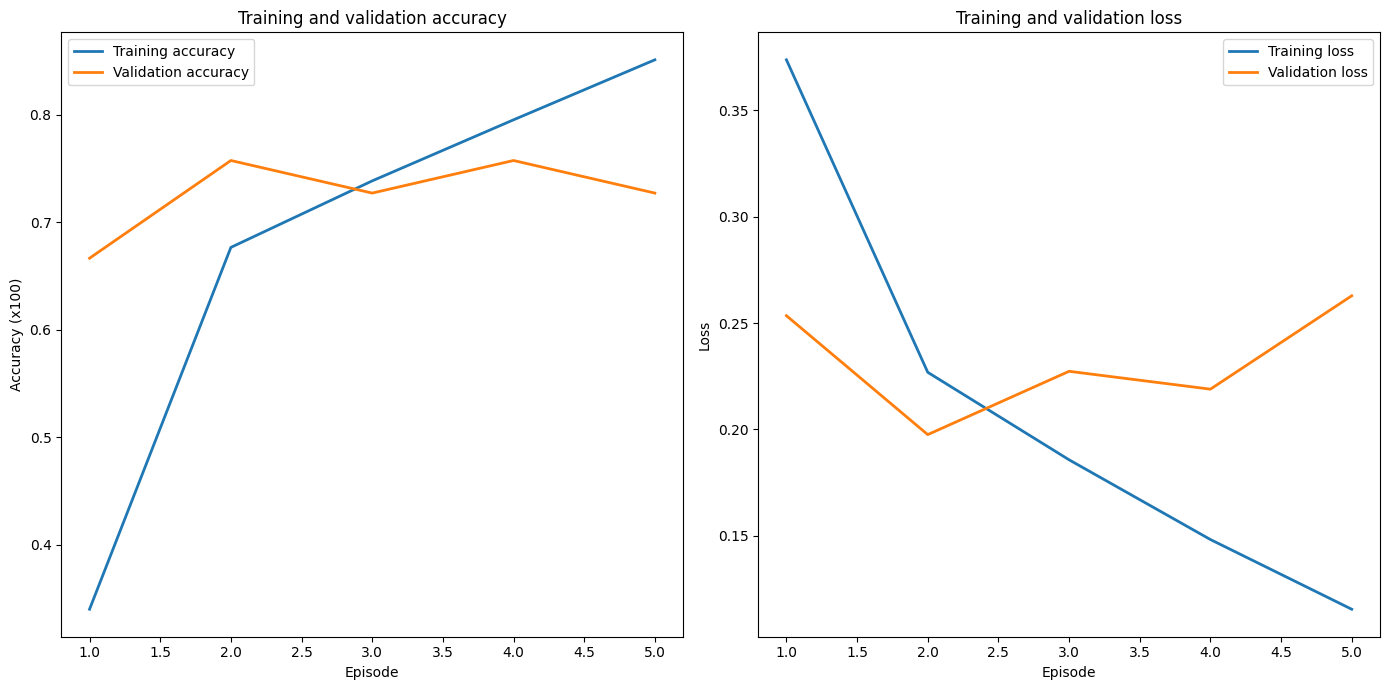

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 7)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

ax[0].set_title('Training and validation accuracy')
ax[0].plot(epochs, acc, label='Training accuracy', linewidth=2.0)
ax[0].plot(epochs, val_acc, label='Validation accuracy', linewidth=2.0)
ax[0].set(xlabel='Episode', ylabel='Accuracy (x100)')
ax[0].legend()


ax[1].set_title('Training and validation loss')
ax[1].plot(epochs, loss, label='Training loss', linewidth=2.0)
ax[1].plot(epochs, val_loss, label='Validation loss', linewidth=2.0)
ax[1].set(xlabel='Episode', ylabel='Loss')
ax[1].legend()


fig.tight_layout()
plt.show()

In [10]:
id_to_label = ["HAPPY", "ANGRY", "HATE", "SURPRISE", "FEAR", "SAD", "OTHER"]

def predict(comment):
    token = tokenizer(list([comment]), return_tensors="np", padding=True, truncation=True)

    # Make predictions on the test data
    predictions = model.predict(dict(token))

    # Convert predictions to class labels
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    return id_to_label[predicted_labels[0]]

def batch_predict(comment):
    token = tokenizer(list(comment), return_tensors="np", padding=True, truncation=True)

    # Make predictions on the test data
    predictions = model.predict(dict(token))

    # Convert predictions to class labels
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    return [id_to_label[pl] for pl in predicted_labels]

In [11]:
predict_one = "امروز حالم خوبه"
print(predict_one)
print(predict(predict_one))

predict_in_batch = [
    "امروز حالم بده",
    "خیلی گشنمه"
    ]
print(predict_in_batch)
print(batch_predict(predict_in_batch))

predict_one = "بریم یک سیگاری بکشیم شاید حال داد"
print(predict_one)
print(predict(predict_one))

predict_one = "موسیقی و شاد بودن حرام نیست"
print(predict_one)
print(predict(predict_one))

predict_one = "زیر آخرین پست های مرحوم گفتن روحت شاد"
print(predict_one)
print(predict(predict_one))

امروز حالم خوبه
1/1 [==============================] - 6s 6s/step
HAPPY
['امروز حالم بده', 'خیلی گشنمه']
1/1 [==============================] - 0s 71ms/step
['SAD', 'SAD']
بریم یک سیگاری بکشیم شاید حال داد
1/1 [==============================] - 0s 72ms/step
OTHER
موسیقی و شاد بودن حرام نیست
1/1 [==============================] - 0s 75ms/step
HAPPY
زیر آخرین پست های مرحوم گفتن روحت شاد
1/1 [==============================] - 0s 75ms/step
SAD
